In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.autonotebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable



from transformers import SegformerFeatureExtractor
from transformers import SegformerForSemanticSegmentation
from huggingface_hub import cached_download, hf_hub_url
from datasets import load_metric

seed = 42
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Currently using "{device.upper()}" device.')

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

batch_size = 4
num_classes = 24
epochs = 20

Currently using "CUDA" device.


[Link to example tutorial](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/SegFormer/Fine_tune_SegFormer_on_custom_dataset.ipynb#scrollTo=MbNeV9xdw7rm)

In [3]:
images_path = r'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/original_images/'
color_masks_path = r'../input/semantic-drone-dataset/RGB_color_image_masks/RGB_color_image_masks/'
masks_path = r'../input/semantic-drone-dataset/dataset/semantic_drone_dataset/label_images_semantic/'

images = glob(images_path + '*.jpg')
colored_masks = glob(color_masks_path + '*.png')
masks = glob(masks_path + '*.png')

images = sorted([str(p) for p in images])
colored_masks = sorted([str(p) for p in colored_masks])
masks = sorted([str(p) for p in masks])

path_df = pd.DataFrame({'image': images, 'color_mask': colored_masks, 'mask': masks})
path_df.sample(2)

,image,color_mask,mask
285,../input/semantic-drone-dataset/dataset/semant...,../input/semantic-drone-dataset/RGB_color_imag...,../input/semantic-drone-dataset/dataset/semant...
39,../input/semantic-drone-dataset/dataset/semant...,../input/semantic-drone-dataset/RGB_color_imag...,../input/semantic-drone-dataset/dataset/semant...


In [4]:
labels = pd.read_csv('../input/semantic-drone-dataset/class_dict_seg.csv')
label_to_id = {v: k for k, v in enumerate(labels['name'].unique())}
id_to_label = {v: k for k, v in label_to_id.items()}

palette = []
for i in range(num_classes):
    color = labels.iloc[i, 1:].values.tolist()
    palette.append(color)

In [5]:
train, test = train_test_split(path_df, test_size=0.1, shuffle=True, random_state=42)
train, valid = train_test_split(train, test_size=0.15, shuffle=True, random_state=42)

train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print(f'Train size: {len(train)}, validation size: {len(valid)} and test size: {len(test)}')

Train size: 306, validation size: 54 and test size: 40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


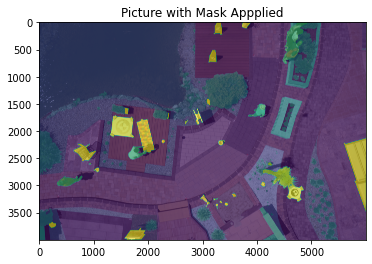

In [8]:
sample_img = path_df.sample(1, random_state=42)

image = Image.open(sample_img['image'].values[0])
cmask = Image.open(sample_img['color_mask'].values[0])
mask = Image.open(sample_img['mask'].values[0])

print('Image Size', np.asarray(image).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(image)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [6]:
class DroneDataset(Dataset):
    def __init__(self, dataframe, feature_extractor):
        self.dataframe = dataframe
        self.feature_extractor = feature_extractor
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, ix):
        row = self.dataframe.loc[ix].squeeze()
        image = Image.open(row['image'])        
        mask = Image.open(row['mask'])
        
        encoded_inputs = self.feature_extractor(image, mask, return_tensors="pt")
        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_()
        
        return encoded_inputs
    

In [7]:
feature_extractor = SegformerFeatureExtractor(reduce_labels=True) # remove background class

train_dataset = DroneDataset(train, feature_extractor)
valid_dataset = DroneDataset(valid, feature_extractor)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

In [9]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b3",
                                                         num_labels=num_classes, 
                                                         id2label=id_to_label, 
                                                         label2id=label_to_id,)

Downloading:   0%|          | 0.00/68.4k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/170M [00:00<?, ?B/s]

Some weights of the model checkpoint at nvidia/mit-b3 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.linear_c.2.proj.bias', 'deco

In [10]:
metric_train = load_metric("mean_iou")
metric_valid = load_metric("mean_iou")

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
model.to(device)
print()

In [11]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.xticks(np.arange(0, 20, 1))
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.xticks(np.arange(0, 20, 1))
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.xticks(np.arange(0, 20, 1))
    plt.legend(), plt.grid()
    plt.show()

In [12]:
train_losses = []
test_losses = []
val_iou = []; val_acc = []
train_iou = []; train_acc = []


for epoch in range(epochs):
    print("Epoch:", epoch+1)
    model.train()
    for idx, batch in enumerate(tqdm(train_dataloader, leave=False)):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
          
            metric_train.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        if idx % 170 == 0:
            metrics = metric_train.compute(num_labels=len(id_to_label), 
                                           ignore_index=255,
                                           reduce_labels=False,
          )

            print("Loss:", loss.item())
            print("Mean_iou:", metrics["mean_iou"])
            print("Mean accuracy:", metrics["mean_accuracy"])
            print('-'*50)
            
    train_losses.append(loss.item())
    train_iou.append(metrics["mean_iou"])
    train_acc.append(metrics["mean_accuracy"])
            
    model.eval()
    print('-'*30, 'Validation', '-'*30)
    for idx, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        
        with torch.no_grad():
            upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            predicted = upsampled_logits.argmax(dim=1)
          
            metric_valid.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        if idx % 19 == 0:
            metrics = metric_valid.compute(num_labels=len(id_to_label), 
                                           ignore_index=255,
                                           reduce_labels=False,
          )

            print("Loss:", loss.item())
            print("Mean_iou:", metrics["mean_iou"])
            print("Mean accuracy:", metrics["mean_accuracy"])
            print('-'*50)
    
    test_losses.append(loss.item())
    val_iou.append(metrics["mean_iou"])
    val_acc.append(metrics["mean_accuracy"])
    #try:
    #    evaluate_test()
    #except:
    #    pass

Epoch: 1


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 3.258082389831543
Mean_iou: 0.00656396976285398
Mean accuracy: 0.029001683350217574
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.5475602746009827
Mean_iou: 0.3391651519841561
Mean accuracy: 0.4280126591068425
--------------------------------------------------
Epoch: 2


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.5858018398284912
Mean_iou: 0.19174374745010947
Mean accuracy: 0.2922843969801012
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.3981013298034668
Mean_iou: 0.34961774850916705
Mean accuracy: 0.4304846417707331
--------------------------------------------------
Epoch: 3


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.3265697956085205
Mean_iou: 0.4345604120896736
Mean accuracy: 0.5162551839307632
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.3525107204914093
Mean_iou: 0.49454135731645016
Mean accuracy: 0.5860160440247347
--------------------------------------------------
Epoch: 4


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.2743750214576721
Mean_iou: 0.5298723710327028
Mean accuracy: 0.6141379006487261
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.322710245847702
Mean_iou: 0.5242868267814983
Mean accuracy: 0.6096913706843439
--------------------------------------------------
Epoch: 5


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.24630585312843323
Mean_iou: 0.572179934419689
Mean accuracy: 0.6581306342309889
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.2934977412223816
Mean_iou: 0.5529140306059321
Mean accuracy: 0.6482895556471738
--------------------------------------------------
Epoch: 6


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.33926376700401306
Mean_iou: 0.5936760734831086
Mean accuracy: 0.6774862813965623
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.3020177185535431
Mean_iou: 0.5627285000965586
Mean accuracy: 0.656172787518651
--------------------------------------------------
Epoch: 7


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.28538838028907776
Mean_iou: 0.6170102374129808
Mean accuracy: 0.700537045548482
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.27219200134277344
Mean_iou: 0.5600591752462347
Mean accuracy: 0.6412731582297863
--------------------------------------------------
Epoch: 8


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.3177086412906647
Mean_iou: 0.6321805458454096
Mean accuracy: 0.7132013317603225
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.277294784784317
Mean_iou: 0.5803243939118968
Mean accuracy: 0.6805505346541206
--------------------------------------------------
Epoch: 9


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.2844430208206177
Mean_iou: 0.6420949968143614
Mean accuracy: 0.7215564226286438
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.2580340802669525
Mean_iou: 0.5853070395586408
Mean accuracy: 0.6863977761001081
--------------------------------------------------
Epoch: 10


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.20430885255336761
Mean_iou: 0.6560642607612096
Mean accuracy: 0.735299803305396
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.2620670795440674
Mean_iou: 0.5865103188552452
Mean accuracy: 0.6868840097396697
--------------------------------------------------
Epoch: 11


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.16990917921066284
Mean_iou: 0.6623441377275531
Mean accuracy: 0.739379964958549
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.2479487508535385
Mean_iou: 0.599244676341815
Mean accuracy: 0.6911655255634487
--------------------------------------------------
Epoch: 12


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.23158378899097443
Mean_iou: 0.676340394168201
Mean accuracy: 0.7517365727703303
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.23574888706207275
Mean_iou: 0.5934457359912026
Mean accuracy: 0.6961267248550593
--------------------------------------------------
Epoch: 13


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.19065219163894653
Mean_iou: 0.6805271355974933
Mean accuracy: 0.7533423725128369
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.24257823824882507
Mean_iou: 0.6043787402791561
Mean accuracy: 0.7045851137231924
--------------------------------------------------
Epoch: 14


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.14471566677093506
Mean_iou: 0.6932076740329115
Mean accuracy: 0.7658386741334439
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.23105452954769135
Mean_iou: 0.6084048675302227
Mean accuracy: 0.7038807097101568
--------------------------------------------------
Epoch: 15


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.16596053540706635
Mean_iou: 0.7012664046499908
Mean accuracy: 0.7716678171489858
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.24893596768379211
Mean_iou: 0.615079516269221
Mean accuracy: 0.7132216754778714
--------------------------------------------------
Epoch: 16


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.1718270182609558
Mean_iou: 0.7115435312730385
Mean accuracy: 0.7802533291328942
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.22922170162200928
Mean_iou: 0.6189482510904565
Mean accuracy: 0.7218789703757861
--------------------------------------------------
Epoch: 17


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.10405479371547699
Mean_iou: 0.7215379502780445
Mean accuracy: 0.7904443679153252
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.22401542961597443
Mean_iou: 0.6227551422611796
Mean accuracy: 0.7169065001912487
--------------------------------------------------
Epoch: 18


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.18808479607105255
Mean_iou: 0.7339734674144996
Mean accuracy: 0.8009061720887742
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.22644835710525513
Mean_iou: 0.6248729624012218
Mean accuracy: 0.7184660490261937
--------------------------------------------------
Epoch: 19


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.1444740742444992
Mean_iou: 0.7433482144560322
Mean accuracy: 0.810091044425599
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.2222413271665573
Mean_iou: 0.6294649981740549
Mean accuracy: 0.7361270097269295
--------------------------------------------------
Epoch: 20


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.20800577104091644
Mean_iou: 0.7573150536395946
Mean accuracy: 0.8230647516967078
--------------------------------------------------
------------------------------ Validation ------------------------------


  0%|          | 0/14 [00:00<?, ?it/s]

Loss: 0.2243705540895462
Mean_iou: 0.6336074084256096
Mean accuracy: 0.7309316390641594
--------------------------------------------------


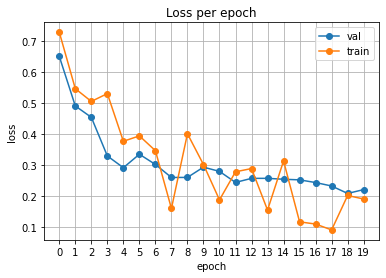

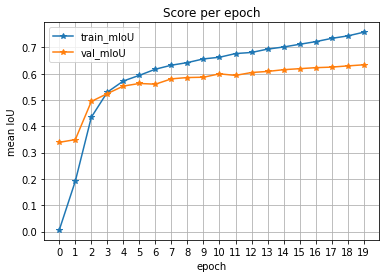

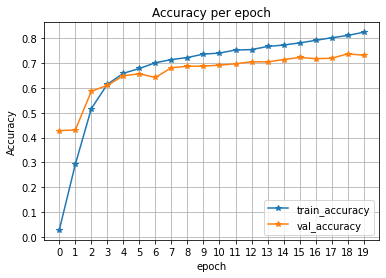

In [13]:
history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc}

plot_loss(history)
plot_score(history)
plot_acc(history)

In [6]:
#last_model_wts = copy.deepcopy(model.state_dict())
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b3",
                                                         num_labels=24, 
                                                         id2label=id_to_label, 
                                                         label2id=label_to_id,)

PATH = f"SegFormer-b3.bin"
torch.save(model.state_dict(), PATH)

Some weights of the model checkpoint at nvidia/mit-b3 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.weight', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_fuse.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.1.proj.b

In [7]:
def load_model(path):
    #model = build_model()
    model.load_state_dict(torch.load(path))
    model.eval()
    return model

In [8]:
model = load_model(PATH)